In [1]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from sklearn.metrics import silhouette_score
import itertools

In [3]:
path = Path('.')
dataframes = {}
columns =  ['dates','subframe_n','subframe_ind','rnti','direction','mcs']
for p in list(path.glob('new_A')):
    for file in tqdm(list(p.glob('*.csv*'))[:1]):
        df = pd.read_csv(file, names = columns)
        with pd.option_context('mode.use_inf_as_null', True):
            df = df.dropna()#fillna(0)#dropna(subset=['subframe_ind', 'rnti', 'direction', 'mcs'], how='all')
        df[['subframe_ind', 'rnti', 'direction', 'mcs']] = df[['subframe_ind', 'rnti', 'direction', 'mcs']].astype(np.int)
        df.dates = pd.to_datetime(df.dates, format='%Y%m%d%H%M%S')
        dataframes[file.parts[-1]]=df#.sort_values('rnti').reset_index(drop = True)

df = pd.concat([dataframes[key] for key in dataframes.keys()])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.60s/it]


In [4]:
df = df[(df.rnti > 10)&(df.rnti != 65535)]
df['date_delta'] = (df['dates'] - df['dates'].min())  / np.timedelta64(1,'s')

df = df.drop(columns = 'dates')
df = df.astype('int32')

In [ ]:
print(df.info())
print(df.describe())
df.head()


 mu = 533.23 and sigma = 306.69



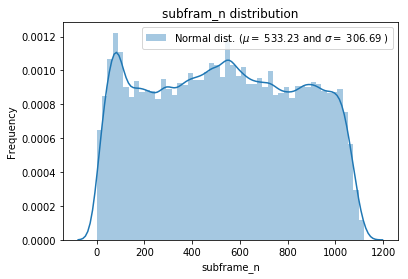

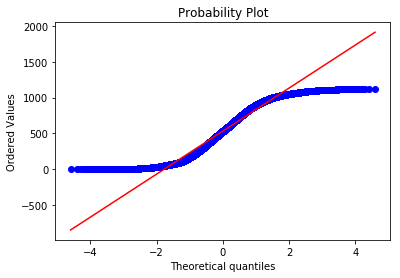

In [19]:
target = 'subframe_n'
plt.figure()
sns.distplot(df[target]);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[target])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('subfram_n distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[target], plot=plt)
plt.show()


 mu = 4.80 and sigma = 2.96



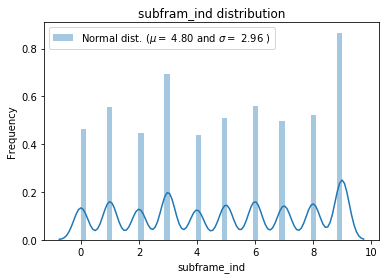

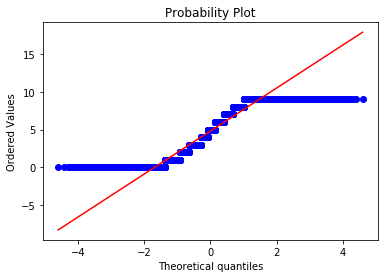

In [20]:
target = 'subframe_ind'
plt.figure()
sns.distplot(df[target]);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[target])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('subfram_ind distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[target], plot=plt)
plt.show()


 mu = 26642.87 and sigma = 10841.61



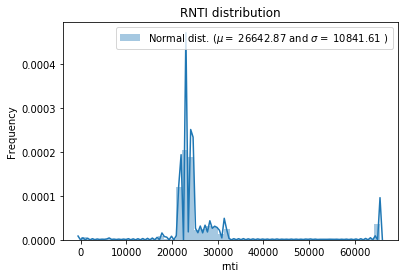

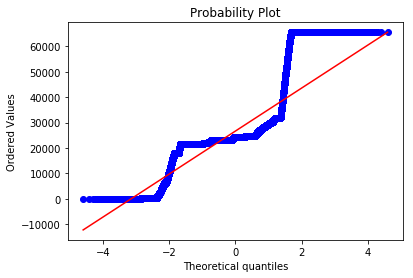

In [21]:
target = 'rnti'
plt.figure()
sns.distplot(df[target]);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[target])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('RNTI distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[target], plot=plt)
plt.show()


 mu = 11.46 and sigma = 9.52



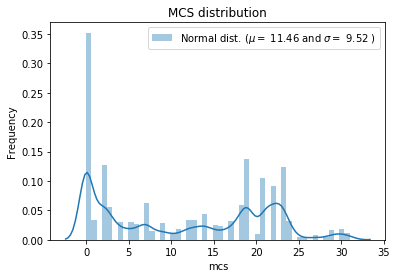

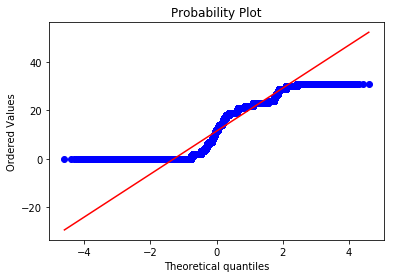

In [22]:
target = 'mcs'
plt.figure()
sns.distplot(df[target]);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[target])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('MCS distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[target], plot=plt)
plt.show()


 mu = 6040.90 and sigma = 1457.88



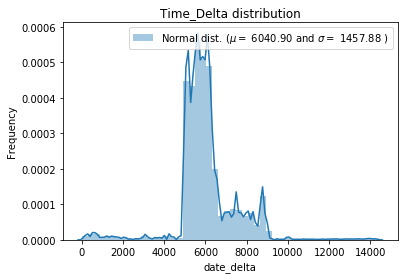

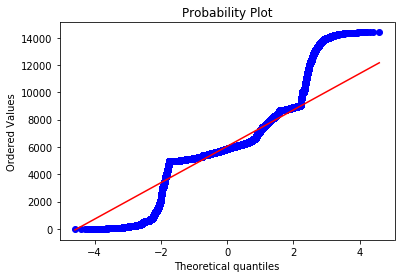

In [23]:
target = 'date_delta'
plt.figure()
sns.distplot(df[target]);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df[target])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Time_Delta distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df[target], plot=plt)
plt.show()

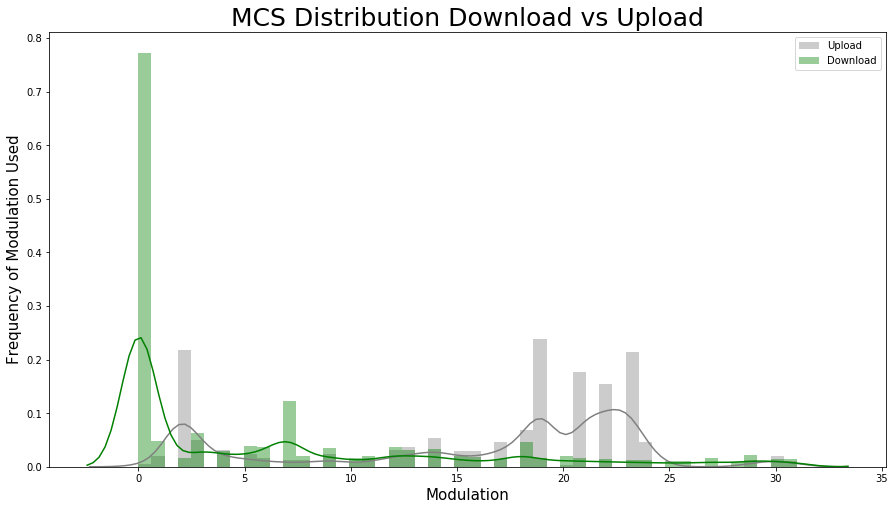

In [26]:
# Kernel Density Plot
fig = plt.figure(figsize=(15,8),)
ax=sns.distplot(df.loc[(df['direction'] == 0),'mcs'] , color='gray',label='Upload')
ax=sns.distplot(df.loc[(df['direction'] == 1),'mcs'] , color='g', label='Download')
plt.title('MCS Distribution Download vs Upload', fontsize = 25)
plt.ylabel("Frequency of Modulation Used", fontsize = 15)
plt.xlabel("Modulation", fontsize = 15)
plt.legend()
plt.show()

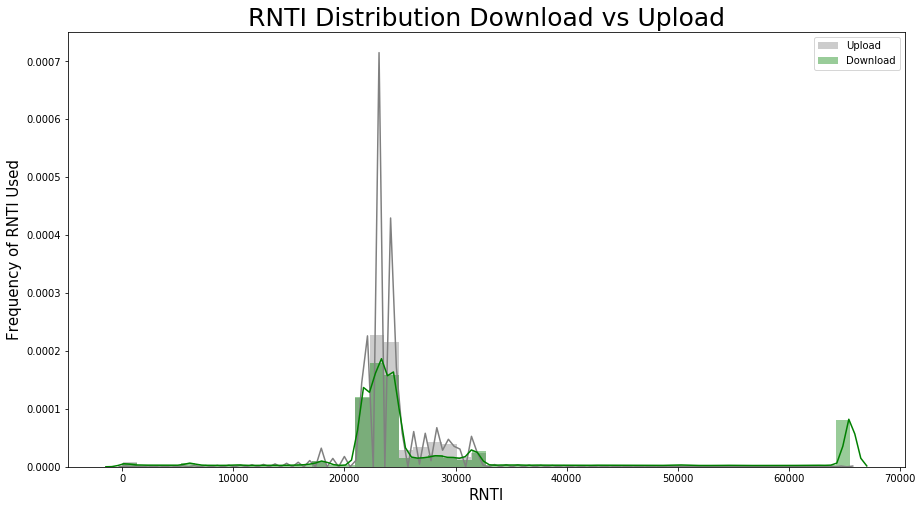

In [27]:
# Kernel Density Plot
fig = plt.figure(figsize=(15,8),)
ax=sns.distplot(df.loc[(df['direction'] == 0),'rnti'] , color='gray',label='Upload')
ax=sns.distplot(df.loc[(df['direction'] == 1),'rnti'] , color='g', label='Download')
plt.title('RNTI Distribution Download vs Upload', fontsize = 25)
plt.ylabel("Frequency of RNTI Used", fontsize = 15)
plt.xlabel("RNTI", fontsize = 15)
plt.legend()
plt.show()

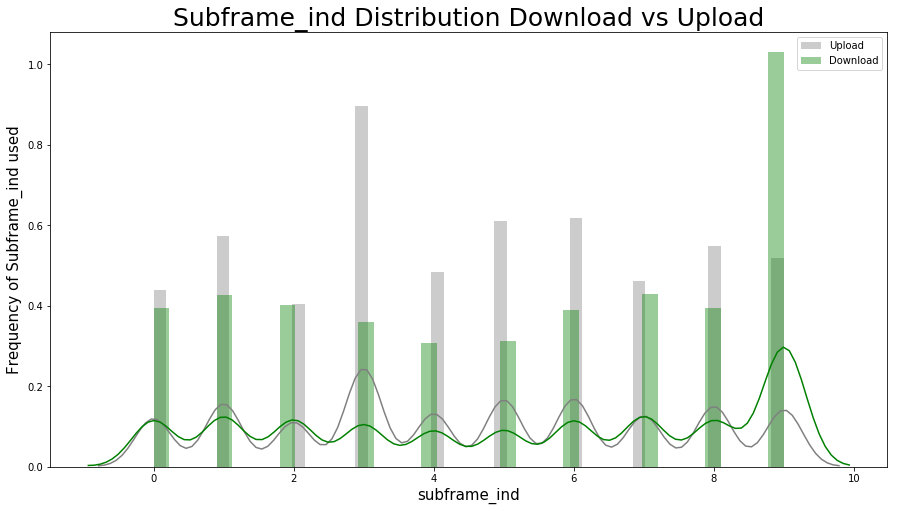

In [28]:
# Kernel Density Plot
fig = plt.figure(figsize=(15,8),)
ax=sns.distplot(df.loc[(df['direction'] == 0),'subframe_ind'] , color='gray',label='Upload')
ax=sns.distplot(df.loc[(df['direction'] == 1),'subframe_ind'] , color='g', label='Download')
plt.title('Subframe_ind Distribution Download vs Upload', fontsize = 25)
plt.ylabel("Frequency of Subframe_ind used", fontsize = 15)
plt.xlabel("subframe_ind", fontsize = 15)
plt.legend()
plt.show()

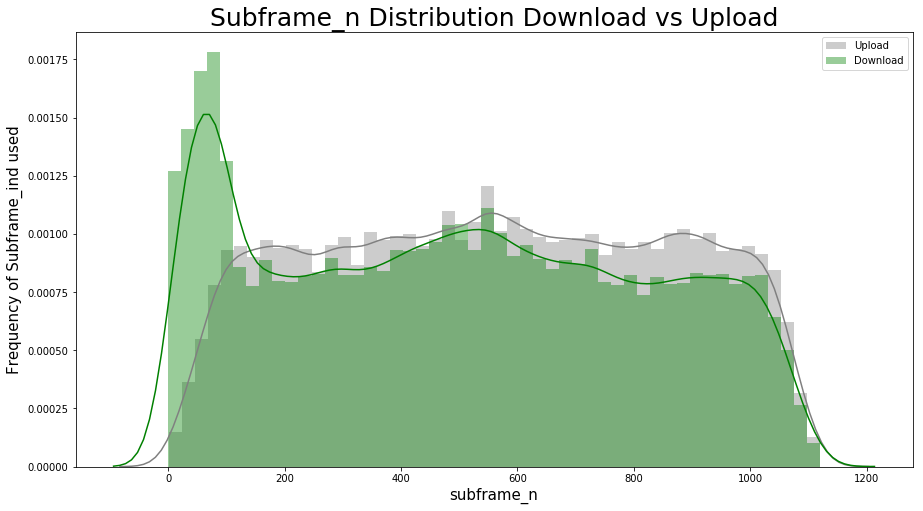

In [29]:
# Kernel Density Plot
fig = plt.figure(figsize=(15,8),)
ax=sns.distplot(df.loc[(df['direction'] == 0),'subframe_n'] , color='gray',label='Upload')
ax=sns.distplot(df.loc[(df['direction'] == 1),'subframe_n'] , color='g', label='Download')
plt.title('Subframe_n Distribution Download vs Upload', fontsize = 25)
plt.ylabel("Frequency of Subframe_ind used", fontsize = 15)
plt.xlabel("subframe_n", fontsize = 15)
plt.legend()
plt.show()

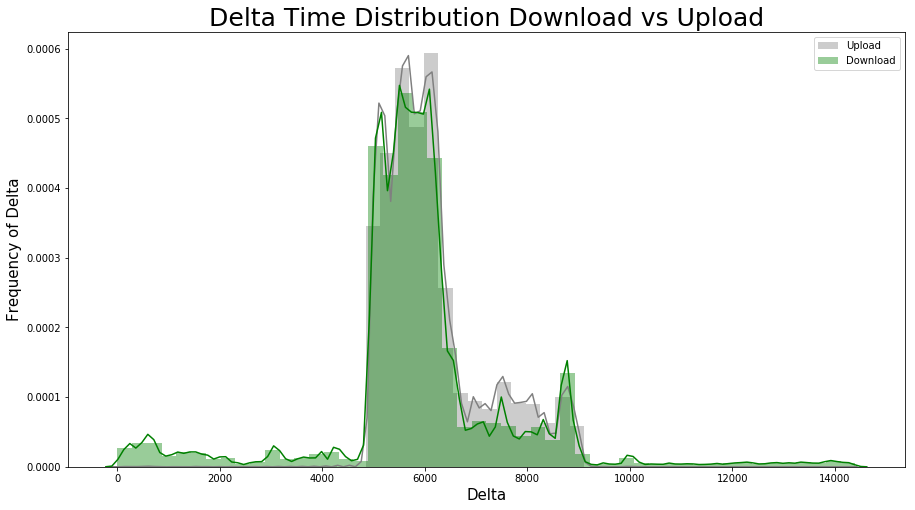

In [30]:
# Kernel Density Plot
fig = plt.figure(figsize=(15,8),)
ax=sns.distplot(df.loc[(df['direction'] == 0),'date_delta'] , color='gray',label='Upload')
ax=sns.distplot(df.loc[(df['direction'] == 1),'date_delta'] , color='g', label='Download')
plt.title('Delta Time Distribution Download vs Upload', fontsize = 25)
plt.ylabel("Frequency of Delta", fontsize = 15)
plt.xlabel("Delta", fontsize = 15)
plt.legend()
plt.show()

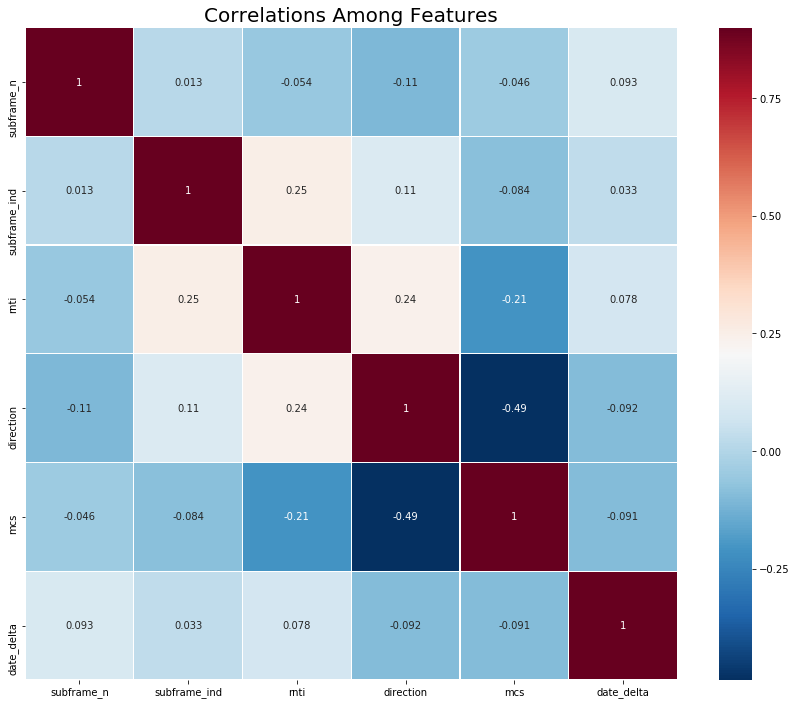

In [31]:
plt.subplots(figsize = (15,12))
sns.heatmap(df.corr(), 
            annot=True,
            #mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20);

# User identification

In [5]:
# rnti is renewed only when 10 seconds pass
delta_rnti_renewal = 10

# list where single dataframe for each user is saved
users = []
count = 0


# structure where on first column the index is set to 1 when rnti has been found 
# and the second column save the index of users and last time lists
# third column have saved the timing of last message from that rnti
current_users = np.zeros((65536,3), dtype = np.int)

# tqdm progress bar
with tqdm(total=len(df)) as pbar:
    for index, row in df.iterrows():
        # if already found user
        if current_users[row.rnti,0]:
            # if the current row is generated by the same rnti because the date is nearer than 10s
            if row.date_delta < current_users[row.rnti,2] + delta_rnti_renewal:
                # already existing user so append the current row 
                users.append(current_users[row.rnti,1])
                # save the last timestep
                current_users[row.rnti,2] = row.date_delta

            else:
                # user found but the rnti has been renewed so append new data
                
                users.append(count)
                current_users[row.rnti,2] = row.date_delta

                current_users[row.rnti,1] = count
                count += 1
        else:
            # user not found so flag the rnti index and append the new data
            users.append(count)

            current_users[row.rnti,2] = row.date_delta

            current_users[row.rnti,0] = 1
            current_users[row.rnti,1] = count
            count += 1
        pbar.update(1)


print('Found {} users'.format(len(set(users))))
df['user'] = users

100%|████████████████████████████████████████████████████████████████████████| 318299/318299 [01:56<00:00, 2733.87it/s]


Found 24707 users


In [8]:
# First message selection
first_messages = []
for i in tqdm(set(users)):
    first_messages.append(df[df.user == i].iloc[0])
first_messages = pd.DataFrame(first_messages)
first_messages.drop(columns = 'user', inplace=True)

100%|██████████| 24707/24707 [00:20<00:00, 1224.77it/s]


In [27]:
def find_n_components(df, m = 20):
    score = []
    best_silhouette = -1

    lowest_bic = np.infty
    bic = []

    n_components_range = range(2, m)
    cv_types = ['full']#['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in tqdm(n_components_range):

            gm = GaussianMixture(n_components=n_components,init_params='kmeans',covariance_type=cv_type)
            gm.fit(df)

            gmm = gm.predict(df)

            bic.append(gm.bic(df))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm_bic = gm

            score.append(silhouette_score(df, gmm))
            if score[-1] > best_silhouette:
                best_score = score[-1]
                best_gmm_silhouette = gm
                
    return (-np.array(score), best_gmm_silhouette), (np.array(bic), best_gmm_bic)

100%|██████████| 18/18 [03:13<00:00, 11.79s/it]


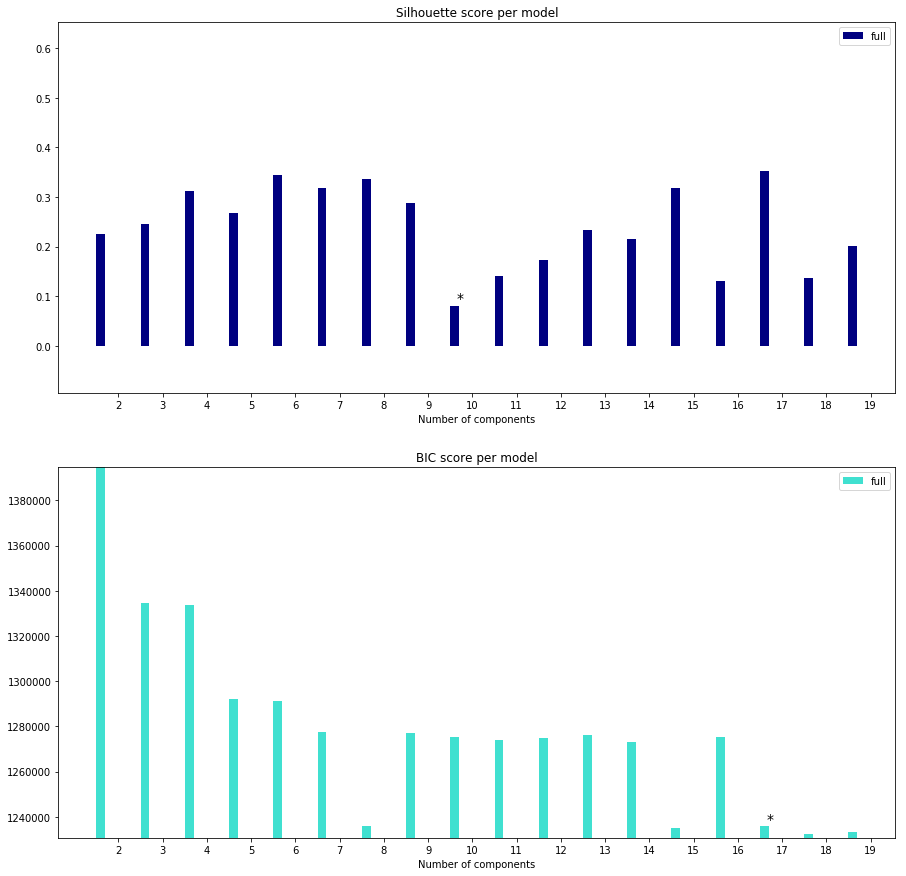

In [28]:
(score, best_gmm_silhouette), (bic, best_gmm_bic) = find_n_components(first_messages)

color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the Silhouette scores
plt.figure(figsize=(15, 15))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, score[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([score.min() * 1.01 - .5 * score.max(), score.max()+.3])
plt.title('Silhouette score per model')
xpos = np.mod(score.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(score.argmin() / len(n_components_range)) +1
plt.text(xpos, score.min() * 0.97 + .03 * score.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 2)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range)) +1
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.show()

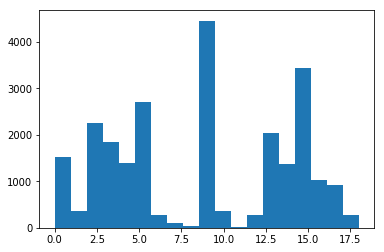

In [30]:
plt.figure()
predicted = best_gmm_silhouette.predict(first_messages)
plt.hist(predicted, bins=best_gmm_silhouette.n_components)
plt.show()

# Clustering

In [23]:
y = df['mcs'].astype('int32')
x = df.loc[:, (df.columns != 'mcs')].astype('int32')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

#rs = RobustScaler()
#rs.fit(X_train)
#X_train = rs.transform(X_train)
#X_test = rs.transform(X_test)

In [132]:
km = KMeans(nclust)
km.fit(X_train)

kmeans = pd.DataFrame(km.predict(X_train))

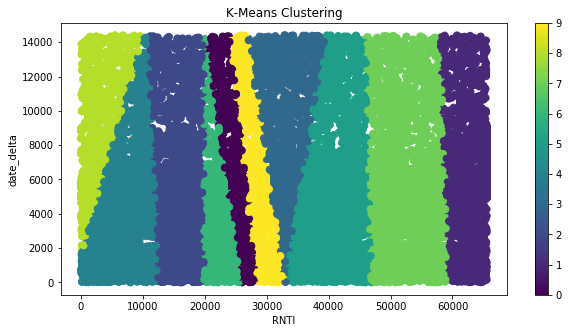

In [123]:
#Plot the clusters obtained using k means
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_train['rnti'],X_train['date_delta'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('RNTI')
ax.set_ylabel('date_delta')
plt.colorbar(scatter)
plt.show()

In [24]:
gm = GaussianMixture(n_components=nclust,init_params='kmeans')
gm.fit(X_train)

gmm = pd.DataFrame(gm.predict(X_train))

In [32]:
np.min(np.array(gmm))

0

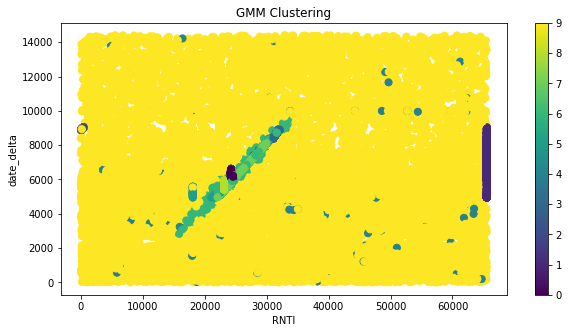

In [125]:
#Plotting the cluster obtained using GMM
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_train['rnti'],X_train['date_delta'],
                     c=gmm[0],s=50)
ax.set_title('GMM Clustering')
ax.set_xlabel('RNTI')
ax.set_ylabel('date_delta')
plt.colorbar(scatter)
plt.show()

In [134]:
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=5000)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
label = ms.fit_predict(X_train)

mss = pd.DataFrame(label)

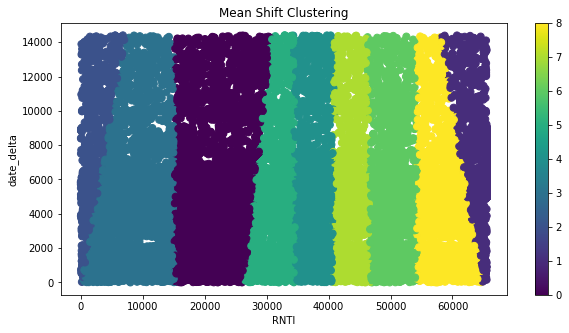

In [127]:
#Plotting the cluster obtained using GMM
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_train['rnti'],X_train['date_delta'],
                     c=mss[0],s=50)
ax.set_title('Mean Shift Clustering')
ax.set_xlabel('RNTI')
ax.set_ylabel('date_delta')
plt.colorbar(scatter)
plt.show()

In [135]:
X_train.insert((X_train.shape[1]),'kmeans',np.array(kmeans))
X_train.insert((X_train.shape[1]),'gmm',np.array(gmm))
X_train.insert((X_train.shape[1]),'mshift',np.array(mss))

kmeans = pd.DataFrame(km.predict(X_test))
gmm = pd.DataFrame(gm.predict(X_test))
mss = pd.DataFrame(ms.predict(X_test))
X_test.insert((X_test.shape[1]),'kmeans',np.array(kmeans))
X_test.insert((X_test.shape[1]),'gmm',np.array(gmm))
X_test.insert((X_test.shape[1]),'mshift',np.array(mss))

In [136]:
X_train.head()

,subframe_n,subframe_ind,rnti,direction,date_delta,kmeans,gmm,mshift
503588,941,4,29885,0,8082,2,3,5
397242,338,6,27017,1,6939,7,6,0
282816,380,6,24571,0,6110,4,5,0
306558,504,1,24571,1,6214,4,6,0
328653,606,9,24245,0,6317,4,5,0


# Regression

In [137]:
from sklearn import metrics


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import  GradientBoostingRegressor

from sklearn.linear_model import ElasticNet, Lasso
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from mlxtend.regressor import StackingRegressor

In [138]:
rf = RandomForestRegressor(n_estimators = 300, verbose = 1, n_jobs = -1, max_depth = 20)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.2s finished


Mean Absolute Error: 3.473415879936322
Mean Squared Error: 29.022438342502856
Root Mean Squared Error: 5.387247752099661


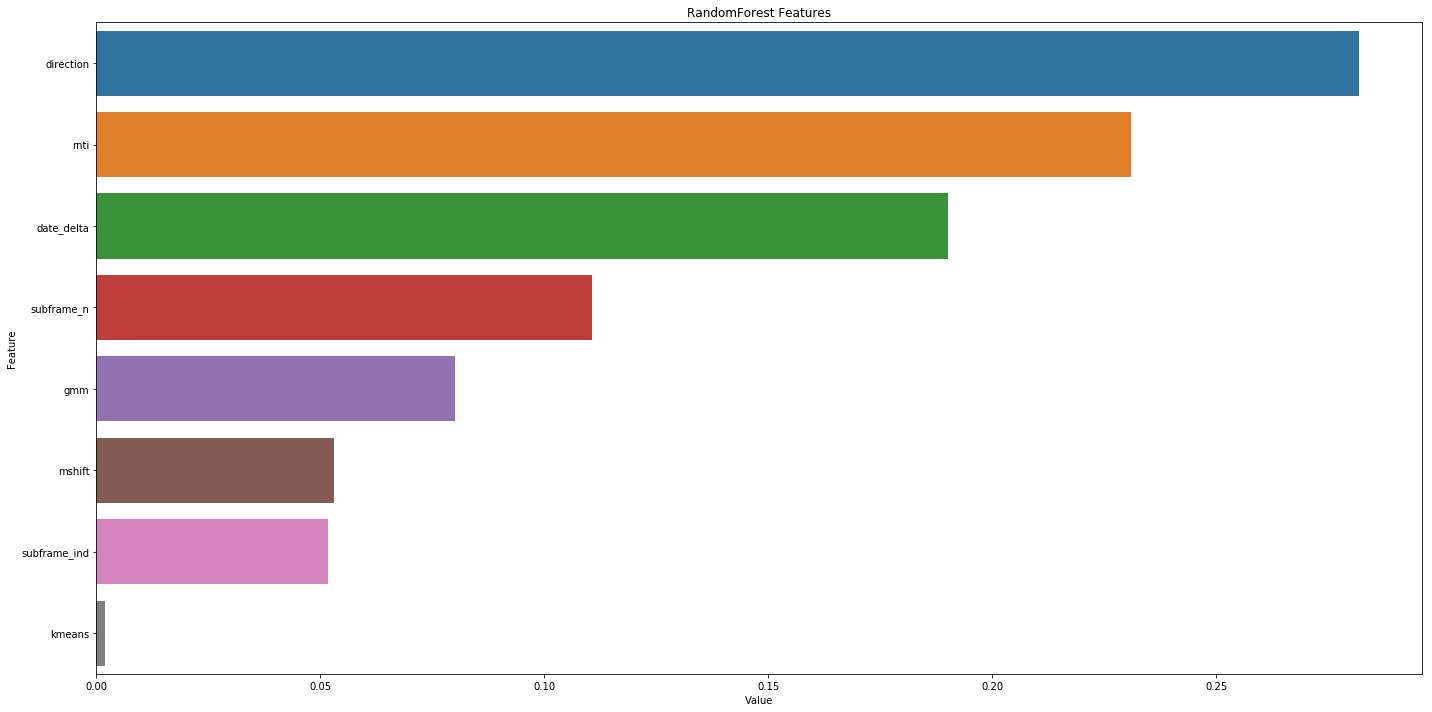

In [141]:
feature_imp = pd.DataFrame(sorted(zip(rf.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RandomForest Features')
plt.tight_layout()
plt.show()

In [142]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso.fit(X_train,y_train)
y_pred = lasso.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 6.576937981468997
Mean Squared Error: 64.58597217740548
Root Mean Squared Error: 8.036539813713704


In [68]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=400,
                              learning_rate=0.1, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.9,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(X_train,y_train)
y_pred = model_lgb.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 


Mean Absolute Error: 3.998963903557427
Mean Squared Error: 36.171792149365835
Root Mean Squared Error: 6.0142989740588915


In [69]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet.fit(X_train,y_train)
y_pred = ENet.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 6.299493963076401
Mean Squared Error: 62.26368236066803
Root Mean Squared Error: 7.8907339557653335


In [70]:
GBoost = GradientBoostingRegressor(n_estimators=400, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5, verbose = 1)
GBoost.fit(X_train,y_train)
y_pred = GBoost.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 4.375277647760089
Mean Squared Error: 38.113814750649965
Root Mean Squared Error: 6.173638696153993


In [71]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=500,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

C:\Users\yurin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Mean Absolute Error: 4.717137033957901
Mean Squared Error: 40.28802369977579
Root Mean Squared Error: 6.347284750172769


In [72]:
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=42)
regr_2.fit(X_train,y_train)
y_pred = regr_2.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 5.9371127461376565
Mean Squared Error: 52.85404911856099
Root Mean Squared Error: 7.2700790311083265


In [73]:
rf_class = RandomForestRegressor(n_estimators = 300, n_jobs = -1, max_depth = 20)
stacked_averaged_models = StackingRegressor(regressors=[model_lgb, GBoost, model_xgb, ENet, rf, regr_2], meta_regressor=rf_class, use_features_in_secondary = True, store_train_meta_features = True, verbose = 3)


stacked_averaged_models.fit(X_train,y_train)
y_pred = stacked_averaged_models.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Fitting 6 regressors...
Fitting regressor1: lgbmregressor (1/6)
LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.9, feature_fraction_seed=9,
       importance_type='split', learning_rate=0.1, max_bin=55,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_data_in_leaf=6, min_split_gain=0.0, min_sum_hessian_in_leaf=11,
       n_estimators=1000, n_jobs=-1, num_leaves=400,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)
Fitting regressor2: gradientboostingregressor (2/6)
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             

C:\Users\yurin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fitting regressor4: pipeline (4/6)
Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False))])
Fitting regressor5: randomforestregressor (5/6)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.9s finished


Fitting regressor6: adaboostregressor (6/6)
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=42)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    3.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.2s finished


Mean Absolute Error: 3.491552049376029
Mean Squared Error: 34.25036780938991
Root Mean Squared Error: 5.852381379352332


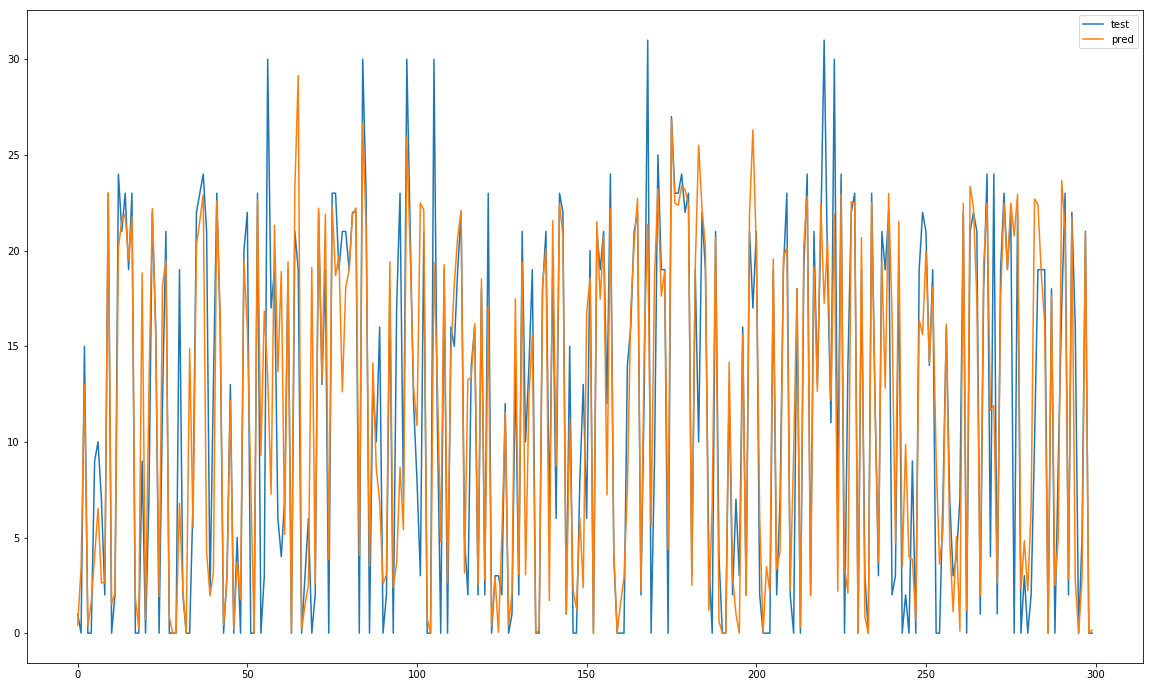

In [75]:
ind = list(range(300))
plt.subplots(figsize = (20,12))
plt.plot(np.array(y_test)[ind], label = 'test')
plt.plot(y_pred[ind], label = 'pred')
plt.legend()
plt.show()

# Classification

In [76]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [77]:
model = RandomForestClassifier(n_estimators=300, min_samples_leaf=10,random_state=1,verbose = 1, n_jobs = -1 )
model.fit(X_train, y_train)
print(classification_report(model.predict(X_test), y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.1s finished


              precision    recall  f1-score   support

           0       0.97      0.61      0.75     10994
           1       0.08      0.34      0.13       152
           2       0.88      0.42      0.57      5170
           3       0.15      0.34      0.21       491
           4       0.13      0.21      0.16       369
           5       0.04      0.12      0.05       188
           6       0.01      0.08      0.02        85
           7       0.05      0.25      0.09       257
           8       0.03      0.13      0.05        76
           9       0.07      0.25      0.11       150
          10       0.04      0.15      0.07        73
          11       0.08      0.20      0.12       134
          12       0.09      0.26      0.14       239
          13       0.13      0.27      0.17       335
          14       0.20      0.36      0.26       494
          15       0.03      0.15      0.05       108
          16       0.08      0.22      0.12       179
          17       0.07    

In [78]:
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255, verbose = 1,
                                 n_estimators=150,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  

clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20)
print(classification_report(clf.predict(X_test), y_test))

[1]	valid_0's multi_logloss: 3.44681
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's multi_logloss: 3.42098
[3]	valid_0's multi_logloss: 3.39113
[4]	valid_0's multi_logloss: 3.3299
[5]	valid_0's multi_logloss: 3.31014
[6]	valid_0's multi_logloss: 3.2927
[7]	valid_0's multi_logloss: 3.26589
[8]	valid_0's multi_logloss: 3.24151
[9]	valid_0's multi_logloss: 3.21936
[10]	valid_0's multi_logloss: 3.19606
[11]	valid_0's multi_logloss: 3.17323
[12]	valid_0's multi_logloss: 3.14152
[13]	valid_0's multi_logloss: 3.11076
[14]	valid_0's multi_logloss: 3.09221
[15]	valid_0's multi_logloss: 3.07313
[16]	valid_0's multi_logloss: 3.05438
[17]	valid_0's multi_logloss: 3.03961
[18]	valid_0's multi_logloss: 3.02411
[19]	valid_0's multi_logloss: 3.00617
[20]	valid_0's multi_logloss: 2.99764
[21]	valid_0's multi_logloss: 2.98857
[22]	valid_0's multi_logloss: 2.98054
[23]	valid_0's multi_logloss: 2.96475
[24]	valid_0's multi_logloss: 2.95246
[25]	valid_0's multi_logloss: 2.94408

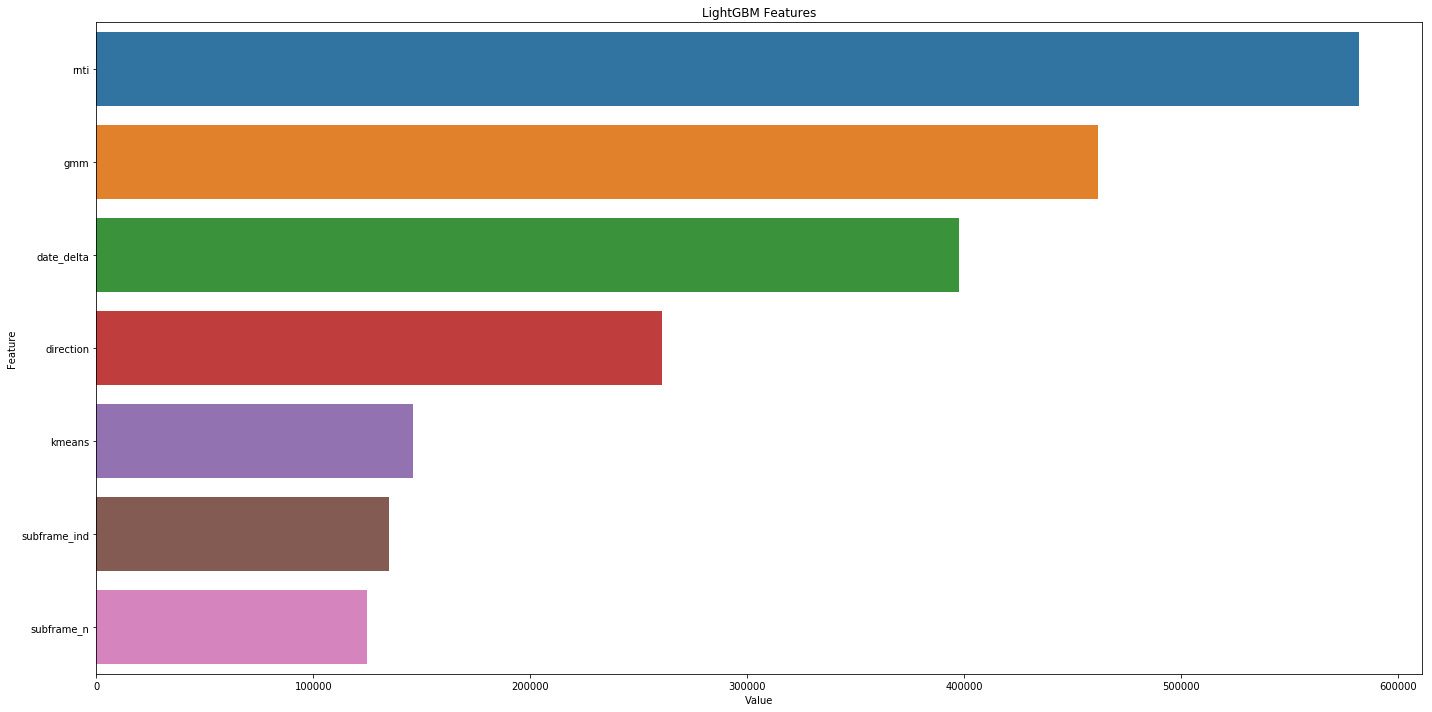

In [79]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')

In [18]:
# rnti is renewed only when 10 seconds pass
delta_rnti_renewal = 10

# list where single dataframe for each user is saved
users = []
count = 0


# structure where on first column the index is set to 1 when rnti has been found 
# and the second column save the idnex of users and last time lists
# third column have saved the timing of last message from that rnti
current_users = np.zeros((65536,3), dtype = np.int)

# tqdm progress bar
with tqdm(total=len(df)) as pbar:
    for index, row in df.iterrows():
        # if already found user
        if current_users[row.rnti,0]:
            # if the current row is generated by the same rnti because the date is nearer than 10s
            if row.date_delta < current_users[row.rnti,2] + delta_rnti_renewal:
                # already existing user so append the current row 
                users.append(current_users[row.rnti,1])
                # save the last timestep
                current_users[row.rnti,2] = row.date_delta

            else:
                # user found but the rnti has been renewed so append new data
                
                users.append(count)
                current_users[row.rnti,2] = row.date_delta

                current_users[row.rnti,1] = count
                count += 1
        else:
            # user not found so flag the rnti index and append the new data
            users.append(count)

            current_users[row.rnti,2] = row.date_delta

            current_users[row.rnti,0] = 1
            current_users[row.rnti,1] = count
            count += 1
        pbar.update(1)


print('Found {} users'.format(len(set(users))))
df['user'] = users

100%|██████████| 318299/318299 [00:32<00:00, 9825.38it/s] 


Found 24707 users


In [12]:
p = [len(u.values) for u in users]

In [26]:
i = 0
while len(df[df.user==i])< 15:
    i+=1
df[df.user==i]

,subframe_n,subframe_ind,rnti,direction,mcs,date_delta,user
14082,10,7,21907,0,12,4955,11295
14083,533,5,21907,0,8,4955,11295
14086,535,7,21907,0,15,4955,11295
14089,537,5,21907,0,2,4955,11295
14090,537,5,21907,1,1,4955,11295
14093,539,7,21907,0,13,4955,11295
14094,541,5,21907,0,15,4955,11295
14098,543,7,21907,0,19,4955,11295
14100,545,5,21907,0,19,4955,11295
14106,547,7,21907,0,14,4955,11295


In [76]:
# get the data

min_len = 15

h, _ = np.histogram(users, bins=np.max(users))
pos = h > min_len
u = [i for i, x in enumerate(pos) if x]

data = []

for rnti in u:
    data.append(df['mcs'][df['user']==rnti].values)
    
print('Number of useful sequences:', len(data))

Number of useful sequences: 1691


In [174]:
import scipy.stats as st
from sklearn import preprocessing, decomposition
import warnings
warnings.filterwarnings('ignore')

def compute_features(sequence):
    
    features = []
    
    # this is adding the first 4 order moments (mean, variance, and higher moments)
    for i in range(4):
        features.append(st.kstat(sequence, i+1))
    
    #features.append(np.std(sequence))
    #features.append(np.max(sequence))
    #features.append(np.min(sequence))
    features.append(st.entropy(sequence))
    features.append(st.kurtosis(sequence))
    features.append(st.skew(sequence))
    #features.append(st.gmean(sequence))
    features.append(st.variation(sequence))
    features.append(st.iqr(sequence))
    features.append(st.sem(sequence))
    features.append(st.shapiro(sequence)[0])
    
    return np.array(features)


# compute the features
num_features = 11
feat = np.zeros((len(data), num_features))

for i in range(len(data)):
    feat[i,:] = compute_features(data[i])
    
feat[np.isnan(feat)] = 0
    
# normalize features
# consider using L2 norm
#norm_feat = preprocessing.normalize(feat, axis=0, norm='max')
norm_feat = preprocessing.scale(feat)

# do the PCA
pca = decomposition.PCA()
reduced = pca.fit_transform(norm_feat)

var = pca.explained_variance_ratio_
print('Variance explained by the components:', var)

Variance explained by the components: [0.39527755 0.26933322 0.16158729 0.06183969 0.03941675 0.03127713
 0.02110044 0.01011271 0.00550842 0.00275787 0.00178893]


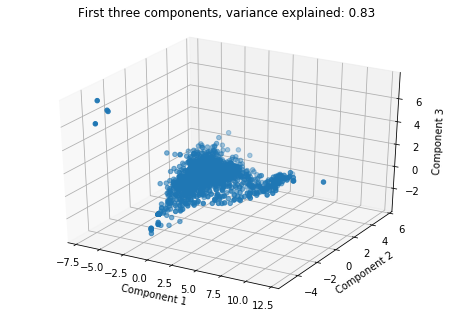

In [175]:
# plot of the first three components
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

rcParams['axes.titlepad'] = 25

fig = plt.figure()
ax = Axes3D(fig)

fin_var = var[0] + var[1] + var[2]
title = 'First three components, variance explained: ' + str(np.around(fin_var, 2))
ax.scatter(reduced[:,0], reduced[:,1], reduced[:,3])
plt.title(title)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()

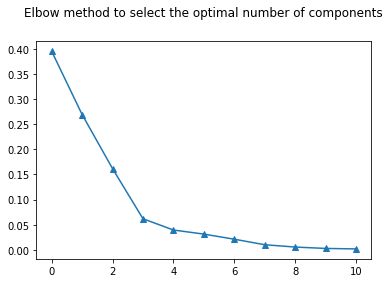

In [176]:
# choose nr of components for PCA
# elbow method

plt.figure()
plt.title('Elbow method to select the optimal number of components')
plt.plot(var, '^-')
plt.show()

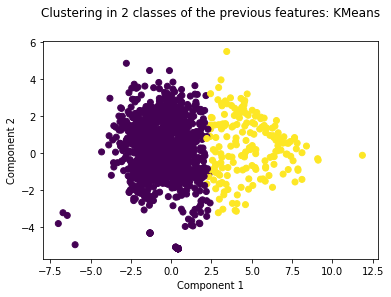

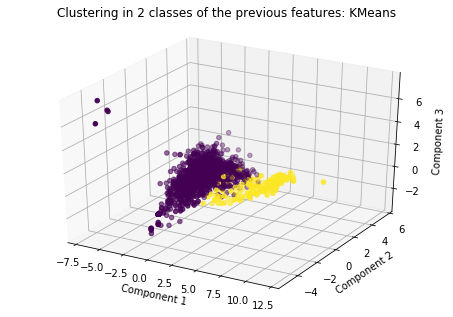

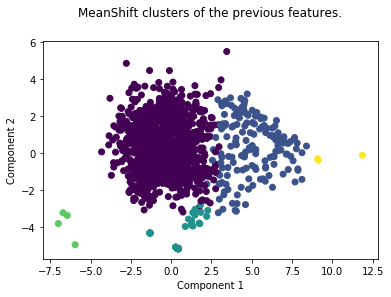

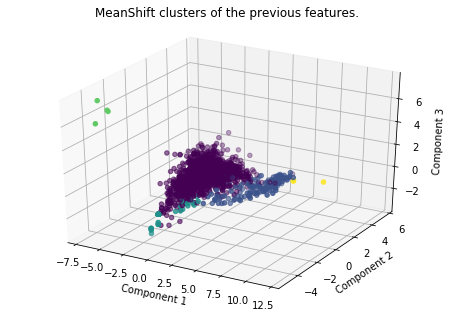

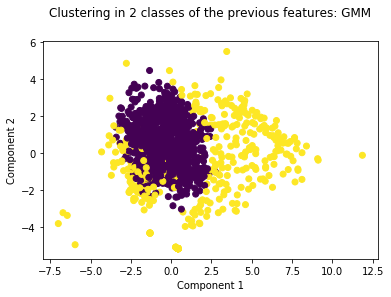

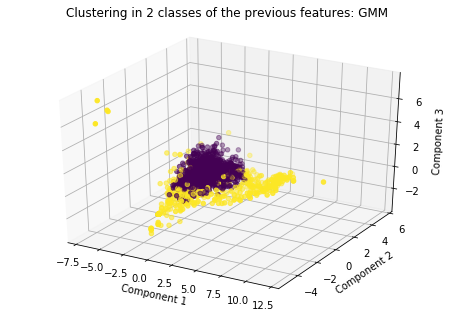

Number of clusters selected by MeanShift: 5


In [180]:
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GMM

n_components = 4
clusters = 2

X = np.zeros((feat.shape[0], n_components))
for i in range(feat.shape[0]):
    X[i,:] = reduced[i,:n_components]
    
# standardize data to feed clustering
#X = preprocessing.scale(X, axis=0)

kmeans = KMeans(n_clusters=clusters).fit(X)
ms = MeanShift().fit(X)
gmm = GMM(n_components=clusters).fit(X)
labels_gmm = gmm.predict(X)
labels_km = kmeans.labels_
labels_ms = ms.labels_

title = 'Clustering in ' + str(clusters) + ' classes of the previous features: '

plt.figure()
plt.scatter(X[:,0], X[:,1], c=labels_km)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(title + 'KMeans')
plt.show()

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:,0], X[:,1], X[:,3], c=labels_km)
plt.title(title + 'KMeans')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()

plt.figure()
plt.scatter(X[:,0], X[:,1], c=labels_ms)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('MeanShift clusters of the previous features.')
plt.show()

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:,0], X[:,1], X[:,3], c=labels_ms)
plt.title('MeanShift clusters of the previous features.')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()

plt.figure()
plt.scatter(X[:,0], X[:,1], c=labels_gmm)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(title + 'GMM')
plt.show()

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:,0], X[:,1], X[:,3], c=labels_gmm)
plt.title(title + 'GMM')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()

n = np.max(labels_ms) + 1
print('Number of clusters selected by MeanShift:', n)

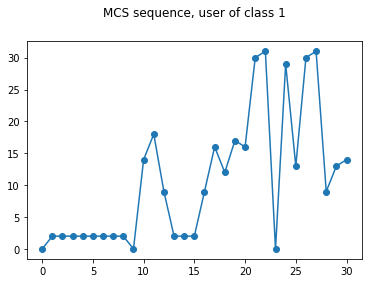

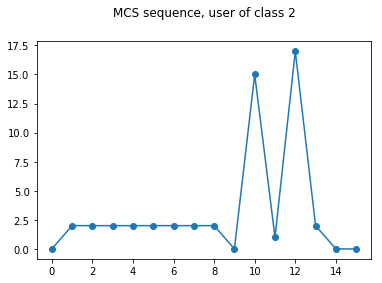

In [188]:
def find_class(data, labels, target):
    
    usr = []
    
    pos = labels == target
    u = [i for i, x in enumerate(pos) if x]
    
    for idx in u:
        usr.append(data[idx])
        
    return usr

def plot_user_mcs(sequence, target):
    
    title = 'MCS sequence, user of class ' + str(target)
    
    plt.figure()
    plt.plot(sequence, 'o-')
    plt.title(title)
    plt.show()
    
    return


usr1 = find_class(data, labels_gmm, 0)
usr2 = find_class(data, labels_gmm, 1)
#usr3 = find_class(data, labels_gmm, 2)

plot_user_mcs(usr1[np.random.randint(0, len(usr1)-1)], 1)
plot_user_mcs(usr2[np.random.randint(0, len(usr2)-1)], 2)
#plot_user_mcs(usr3[np.random.randint(0, len(usr3)-1)], 3)